In [1]:
import sys
sys.path.append('../')

import numpy as np
import pylab as plt

import torch
import torch.nn as nn
import torch.nn.functional as F


from sklearn import datasets
from notebook_utils import block_print, enable_print

/home/denis/miniconda3/envs/uncertainty_evaluation/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


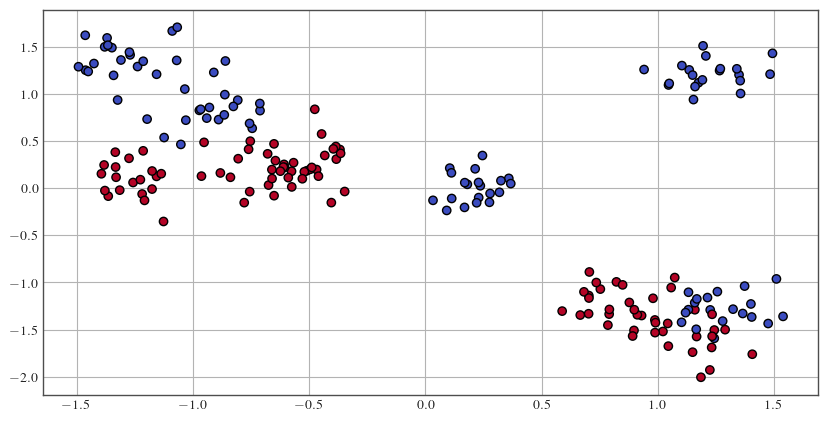

In [2]:
X, y = datasets.make_moons(100, noise=.1, random_state=42)
# X, y = datasets.make_circles(500, noise=.02)
X, y = datasets.make_blobs([20 for _ in range(10)], random_state=12)
y %= 2
X = (X - X.mean(0)) / X.std(0)
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).long()

train_ds = torch.utils.data.TensorDataset(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

In [3]:
class Net(nn.Module):
    def __init__(self,
                 num_classes: int,
                 dropout_rate: int = .2,
                 feature_dim: int = 128,
                 ):
        super().__init__()

        self.first = nn.Linear(2, feature_dim)
        self.first_dropout = nn.Dropout(dropout_rate)
        self.hidden = nn.Linear(feature_dim, feature_dim)
        self.hidden_dropout = nn.Dropout(dropout_rate)
        self.last = nn.Linear(feature_dim, num_classes)
        self.act = nn.ReLU()

    def forward(self, x, return_features=False):
        x = self.act(self.first(x))
        x = self.first_dropout(x)
        x = self.act(self.hidden(x))
        x = self.hidden_dropout(x)
        out = self.last(x)
        if return_features:
            return out, x
        return out

    @torch.inference_mode()
    def get_probas(self, dataloader, device):
        self.to(device)
        self.eval()
        all_logits = []
        for samples, _ in dataloader:
            logits = self(samples.to(device))
            all_logits.append(logits)
        logits = torch.cat(all_logits)
        probas = logits.softmax(-1)
        return probas

    @torch.inference_mode()
    def get_grad_embedding(self, dataloader, n_samples, device):
        self.eval()
        self.to(device)
        feature_dim = 128
        self.num_classes = 2

        embedding = torch.zeros([n_samples, feature_dim * self.num_classes])
        for inputs, _ in dataloader:
            logits, features = self(inputs.to(device), return_features=True)
            logits = logits.cpu()
            features = features.cpu()

            probas = logits.softmax(-1)
            max_indices = probas.argmax(-1)

            # TODO: optimize code
            # for each sample in a batch and for each class
            for n in range(len(inputs)):
                for c in range(self.num_classes):
                    if c == max_indices[n]:
                        embedding[n, feature_dim * c: feature_dim * (c+1)] = features[n] * (1 - probas[n, c])
                    else:
                        embedding[n, feature_dim * c: feature_dim * (c+1)] = features[n] * (-1 * probas[n, c])
        return torch.Tensor(embedding)

In [4]:
def dataset_to_xy(dataset):
    X, y = [], []
    for inp, tar in dataset:
        X.append(inp)
        y.append(tar)
    X = torch.stack(X).float()
    y = torch.Tensor(y).long()
    return X, y

@torch.no_grad()
def plot_contour(model, dataset, unlabeled_indices, labeled_indices, ax=None):
    X, y = dataset_to_xy(dataset)

    model.eval()
    model.cpu()
    if ax:
        plt.sca(ax)
    domain = 5
    xx, yy = torch.meshgrid(torch.linspace(-domain, domain, 51), torch.linspace(-domain, domain, 51))
    zz = torch.stack((xx.flatten(), yy.flatten()), dim=1)

    logits = model(zz)
    probas = logits.softmax(-1)
    zz = probas[:, 1].view(xx.shape)

    # plt.title(f"Ep {}")
    plt.scatter(X[unlabeled_indices, 0], X[unlabeled_indices, 1], s=1)
    plt.scatter(X[labeled_indices, 0], X[labeled_indices, 1], c=y[labeled_indices], s=100)
    plt.contourf(xx, yy, zz, alpha=.8, zorder=-1, levels=np.linspace(0, 1, 6))
    plt.colorbar()

Using train_dataset for queries. Make sure that there are no augmentations used.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/home/denis/miniconda3/envs/uncertainty_evaluation/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484809662/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


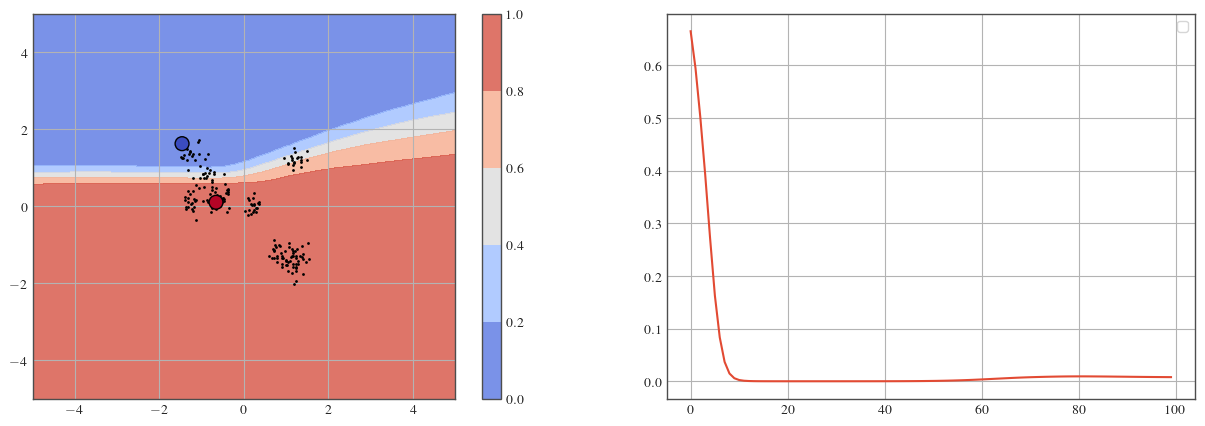

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


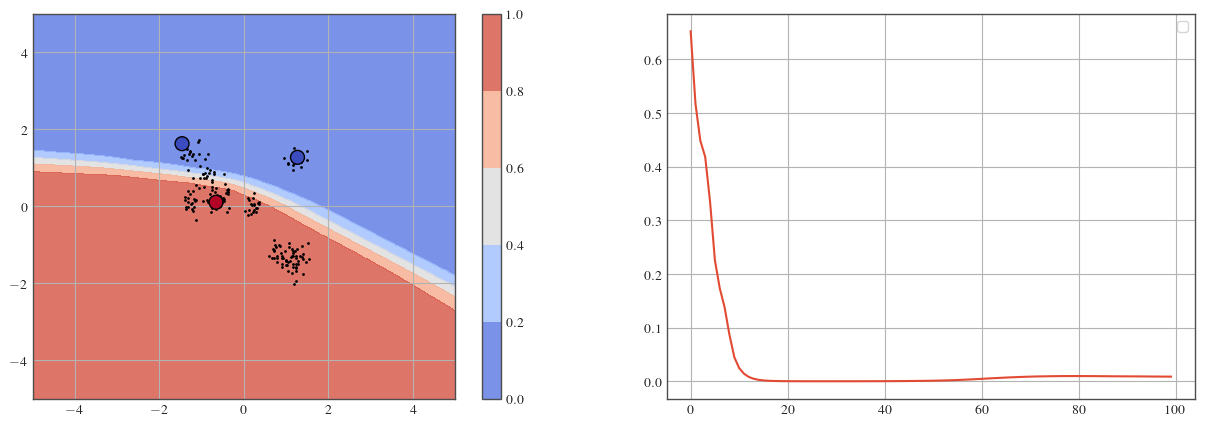

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


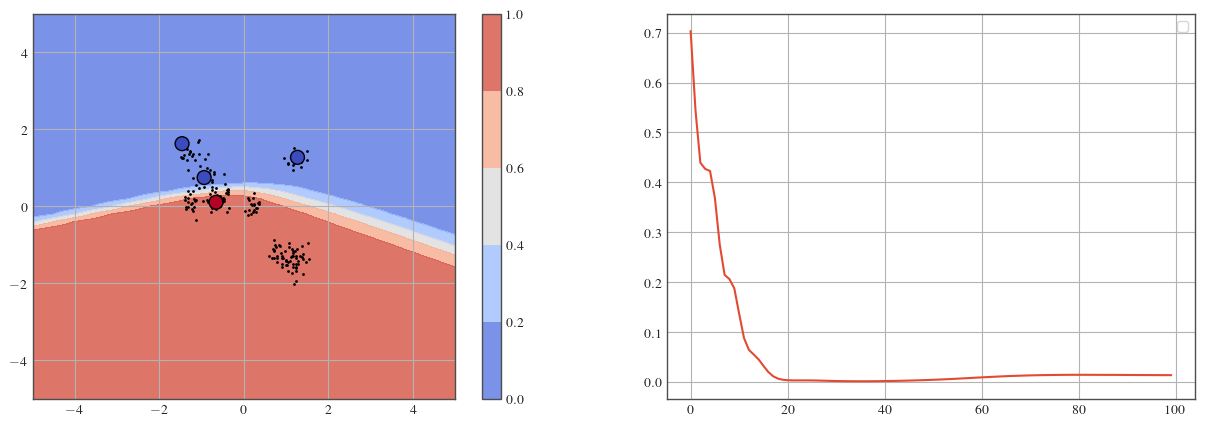

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


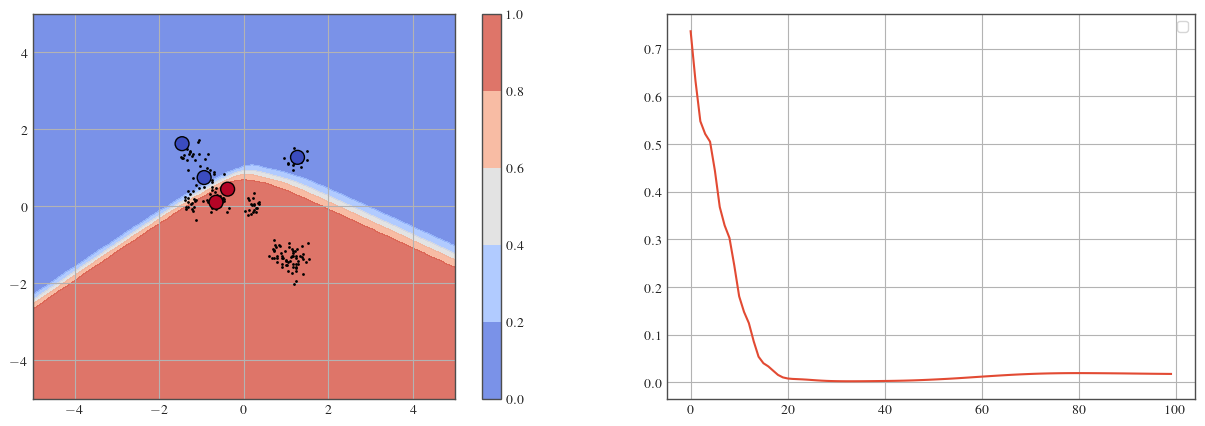

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


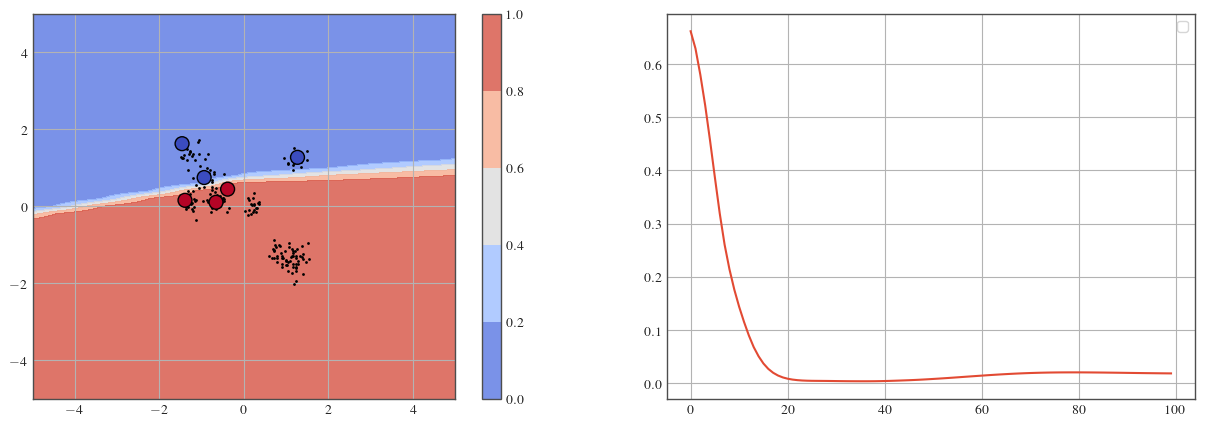

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


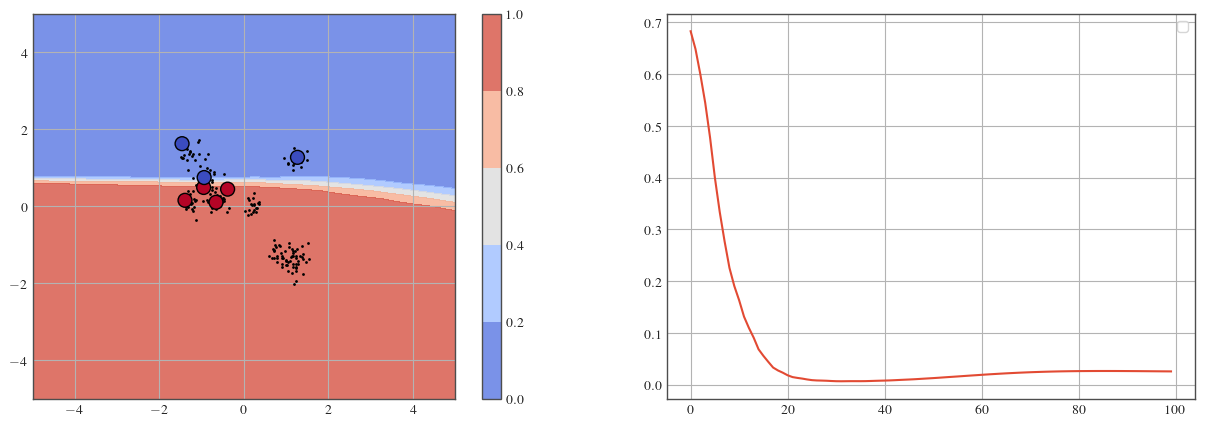

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


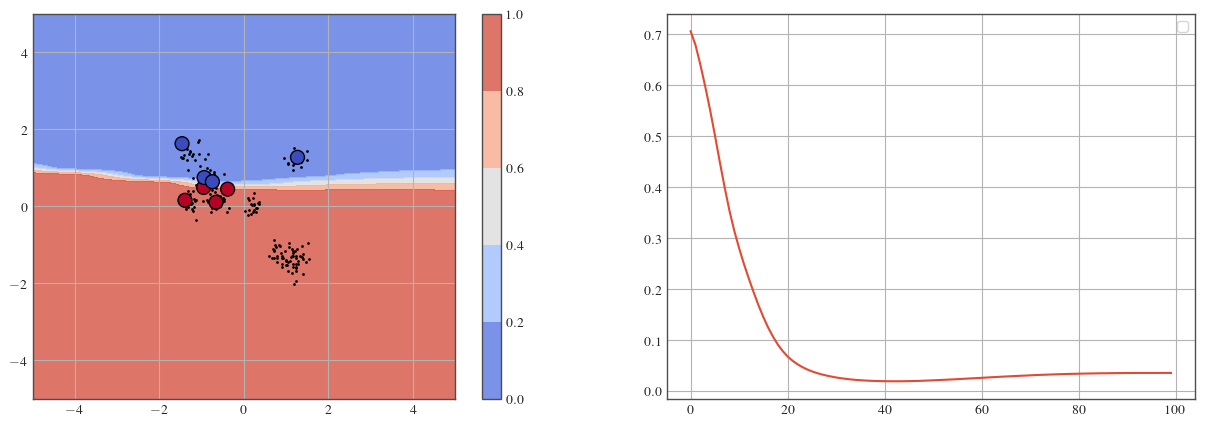

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


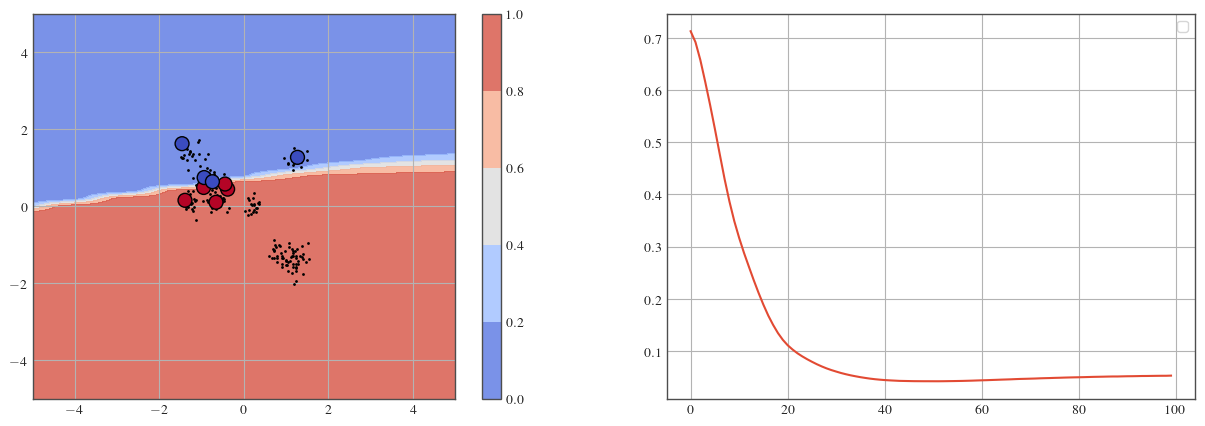

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


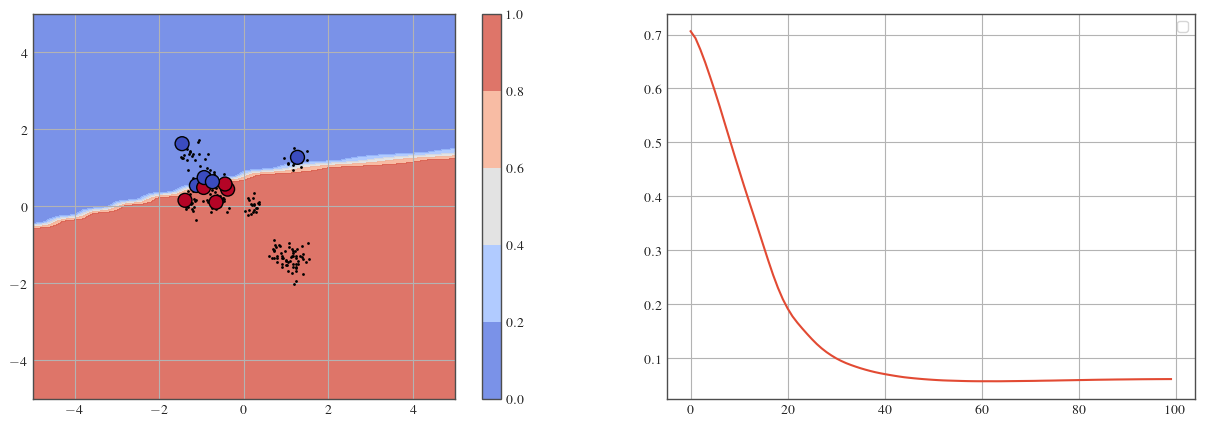

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


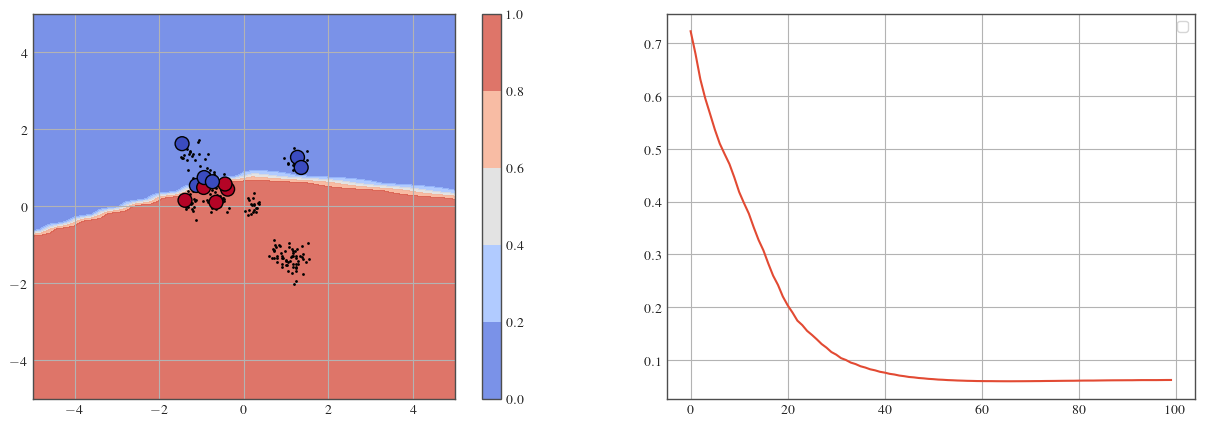

In [5]:
from dal_toolbox.models.deterministic.train import train_one_epoch
from dal_toolbox.active_learning.data import ALDataset
from dal_toolbox.active_learning.strategies import uncertainty

# Train args
torch.manual_seed(0)
dropout_rate = 0.0
optimizer_params = dict(lr=1e-1, weight_decay=1e-2, momentum=.9)
epochs = 100
n_cycles = 10

# AL Setup
al_dataset = ALDataset(train_ds)
al_dataset.random_init(2)
uncertainty_sampling = uncertainty.UncertaintySampling()

for i_cycle in range(n_cycles):
    if i_cycle != 0:
        indices = uncertainty_sampling.query(
            model,
            al_dataset.query_dataset,
            al_dataset.unlabeled_indices,
            acq_size=1
        )
        al_dataset.update_annotations(indices)

    model = Net(dropout_rate=dropout_rate, num_classes=2)
    optimizer = torch.optim.SGD(model.parameters(), **optimizer_params)
    criterion = nn.CrossEntropyLoss()
    history = []

    train_loader = torch.utils.data.DataLoader(al_dataset.labeled_dataset, batch_size=32)
    for i in range(epochs):
        block_print()
        train_stats = train_one_epoch(model, train_loader, criterion, optimizer, device='cuda', epoch=i)
        enable_print()
        history.append(train_stats)

    plt.figure(figsize=(15, 5))
    plt.subplot(122)
    plt.plot([d[f'train_loss'] for d in history])
    plt.legend()
    plot_contour(model, al_dataset.query_dataset, al_dataset.unlabeled_indices, al_dataset.labeled_indices, ax=plt.subplot(121))
    plt.show()